# 모델2 : 맥동성

## 모델구성
- 모델 복잡도 증가
- 다이아몬드형 모델 구성
  - 은닉층9개
    - 은닉1 : 노드12 (특성 수=12)
    - 은닉2 : X2
    - 은닉3 : X2
    - 은닉4 : X2
    - 은닉5 : X2
    - 은닉6 : /2
    - 은닉7 : /2
    - 은닉8 : /2
    - 은닉9 : /2

## 가설 : 모델을 복잡하게 만들어 학습을 진행하면 과적합이 발생하고, 성능이 오를 것
- 다이아몬드형으로 모델 구성

## 결과
- 기존모델의 성능
  - Epoch : 10 , lr : 0.001
  - Train Loss : 1.014
  - Test Accuracy = 0.976
  - Test Precision = 0.926
  - Test Recall = 0.789
  - Test F1 = 0.852
- 모델링 결과
  - Test Loss : 0.074 / Accuracy  : 0.978
- 평가
  - 200에포크 이후로 성능이 오르지 않아 440에포크에 조기종료 되었음
  - 훈련점수와 검증점수의 차이가 없어 과소적합이 의심됨
  - 성능을 올리기 위하여 복잡도를 증가시키는 방향의 개선 필요

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/binary_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [3]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 학습 데이터 분리
    X = df.drop('target_class', axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 표준화
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, node_n=8, dout=0.01):
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)
    
    dense1  = keras.layers.Dense(node_n, kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(node_n*2, kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(node_n*4, kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    outputs = keras.layers.Dense(1)(dout3)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.0001),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
        )
    return model

In [4]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(14318, 8) (3580, 8) (14318,) (3580,)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,14318.000000,1.431800e+04
mean,4.937771e-17,1.985033e-17,4.168570e-17,1.215833e-17,2.679795e-17,4.081725e-17,0.000000,6.252855e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00
min,-4.120136e+00,-3.207467e+00,-2.235779e+00,-5.770065e-01,-4.188843e-01,-9.702420e-01,-2.481473,-1.010623e+00
25%,-4.023072e-01,-6.137926e-01,-4.266299e-01,-3.186363e-01,-3.605269e-01,-6.075160e-01,-0.564632,-6.588786e-01
50%,1.541275e-01,6.343979e-02,-2.415434e-01,-2.553492e-01,-3.306753e-01,-4.016201e-01,0.028258,-2.053026e-01
75%,6.282295e-01,6.600747e-01,-6.613046e-04,-1.334971e-01,-2.407483e-01,1.029766e-01,0.531815,3.272613e-01
max,3.198297e+00,6.588416e+00,7.212419e+00,1.092778e+01,6.832434e+00,4.346189e+00,5.834657,1.022672e+01


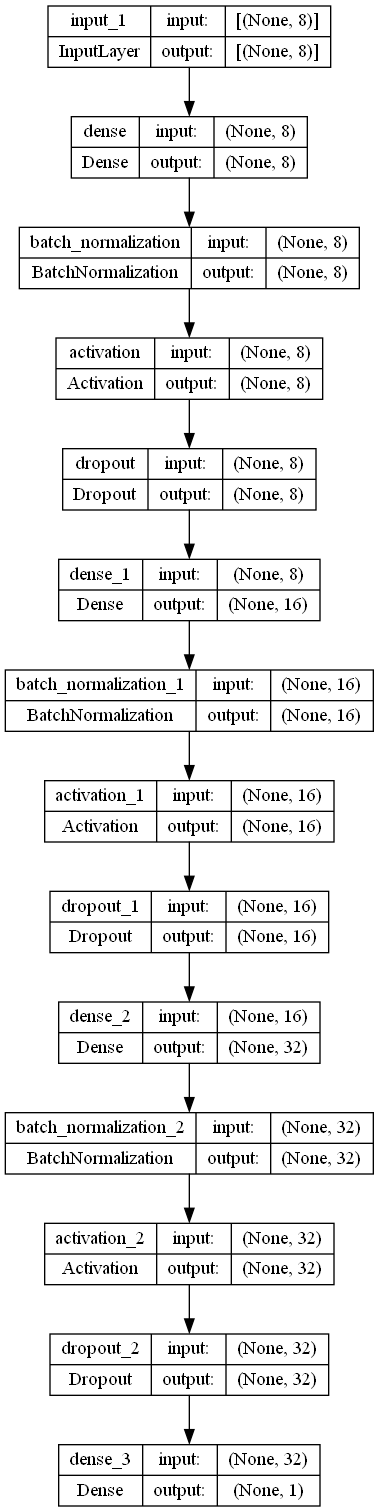

In [5]:
model = get_model(len(X_train.columns))
keras.utils.plot_model(model, show_shapes=True, to_file='model1_model.png')

In [7]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                        , min_delta=0.000001
                                        , patience=EPOCHS//5)

# 모델 저장
checkpoint_path = 'model1.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_accuracy'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback()]
                )

# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss : {loss:.3f} / Accuracy  : {accuracy:.3f}')

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / End training
112/112 [==============================] - 1s 7ms/step - loss: 0.4302 - accuracy: 0.9785
Test Loss : 0.430 / Accuracy  : 0.978


In [8]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model1.json')

with open('model1.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,accuracy,val_loss,val_accuracy
0,1.522964,0.884582,0.519376,0.919344
1,1.440095,0.889384,0.541336,0.919344
2,1.387000,0.896106,0.561112,0.919693
3,1.357960,0.899686,0.583549,0.920042
4,1.315251,0.900297,0.650062,0.919693
...,...,...,...,...
654,0.391217,0.975205,0.356795,0.980098
655,0.387084,0.975904,0.356761,0.980098
656,0.379789,0.976689,0.356667,0.979749
657,0.389429,0.975380,0.356720,0.980098


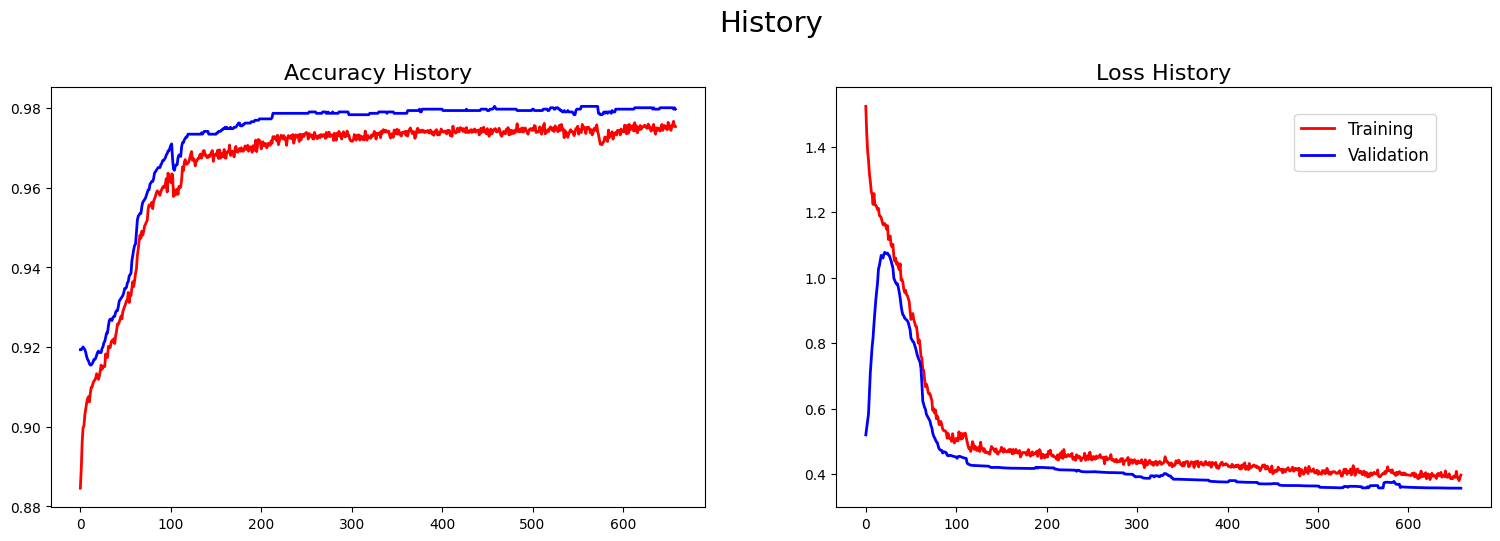

In [9]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_history.png', dpi=80, bbox_inches='tight')